# What's this PyTorch business?

You've written a lot of code in this assignment to provide a whole host of neural network functionality. Dropout, Batch Norm, and 2D convolutions are some of the workhorses of deep learning in computer vision. You've also worked hard to make your code efficient and vectorized.

For the last part of this assignment, though, we're going to leave behind your beautiful codebase and instead migrate to one of two popular deep learning frameworks: in this instance, PyTorch (or TensorFlow, if you switch over to that notebook). 

### What is PyTorch?

PyTorch is a system for executing dynamic computational graphs over Tensor objects that behave similarly as numpy ndarray. It comes with a powerful automatic differentiation engine that removes the need for manual back-propagation. 

### Why?

* Our code will now run on GPUs! Much faster training. When using a framework like PyTorch or TensorFlow you can harness the power of the GPU for your own custom neural network architectures without having to write CUDA code directly (which is beyond the scope of this class).
* We want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand. 
* We want you to stand on the shoulders of giants! TensorFlow and PyTorch are both excellent frameworks that will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 
* We want you to be exposed to the sort of deep learning code you might run into in academia or industry.

### PyTorch versions
This notebook assumes that you are using **PyTorch version 0.4**. Prior to this version, Tensors had to be wrapped in Variable objects to be used in autograd; however Variables have now been deprecated. In addition 0.4 also separates a Tensor's datatype from its device, and uses numpy-style factories for constructing Tensors rather than directly invoking Tensor constructors.

## How will I learn PyTorch?

Justin Johnson has made an excellent [tutorial](https://github.com/jcjohnson/pytorch-examples) for PyTorch. 

You can also find the detailed [API doc](http://pytorch.org/docs/stable/index.html) here. If you have other questions that are not addressed by the API docs, the [PyTorch forum](https://discuss.pytorch.org/) is a much better place to ask than StackOverflow.


# Table of Contents

This assignment has 5 parts. You will learn PyTorch on different levels of abstractions, which will help you understand it better and prepare you for the final project. 

1. Preparation: we will use CIFAR-10 dataset.
2. Barebones PyTorch: we will work directly with the lowest-level PyTorch Tensors. 
3. PyTorch Module API: we will use `nn.Module` to define arbitrary neural network architecture. 
4. PyTorch Sequential API: we will use `nn.Sequential` to define a linear feed-forward network very conveniently. 
5. CIFAR-10 open-ended challenge: please implement your own network to get as high accuracy as possible on CIFAR-10. You can experiment with any layer, optimizer, hyperparameters or other advanced features. 

Here is a table of comparison:

| API           | Flexibility | Convenience |
|---------------|-------------|-------------|
| Barebone      | High        | Low         |
| `nn.Module`     | High        | Medium      |
| `nn.Sequential` | Low         | High        |

# Part I. Preparation

First, we load the CIFAR-10 dataset. This might take a couple minutes the first time you do it, but the files should stay cached after that.

In previous parts of the assignment we had to write our own code to download the CIFAR-10 dataset, preprocess it, and iterate through it in minibatches; PyTorch provides convenient tools to automate this process for us.

In [1]:
# if the notebook is runned on google colab
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

tcmalloc: large alloc 1073750016 bytes == 0x5c110000 @  0x7fa5529c41c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

from time import time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

print(torch.__version__)
print(torch.cuda.is_available())

0.4.0
True


In [0]:
NUM_TRAIN = 49000

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./cs231n/datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

You have an option to **use GPU by setting the flag to True below**. It is not necessary to use GPU for this assignment. Note that if your computer does not have CUDA enabled, `torch.cuda.is_available()` will return False and this notebook will fallback to CPU mode.

The global variables `dtype` and `device` will control the data types throughout this assignment. 

In [3]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


# Part II. Barebones PyTorch

PyTorch ships with high-level APIs to help us define model architectures conveniently, which we will cover in Part II of this tutorial. In this section, we will start with the barebone PyTorch elements to understand the autograd engine better. After this exercise, you will come to appreciate the high-level model API more.

We will start with a simple fully-connected ReLU network with two hidden layers and no biases for CIFAR classification. 
This implementation computes the forward pass using operations on PyTorch Tensors, and uses PyTorch autograd to compute gradients. It is important that you understand every line, because you will write a harder version after the example.

When we create a PyTorch Tensor with `requires_grad=True`, then operations involving that Tensor will not just compute values; they will also build up a computational graph in the background, allowing us to easily backpropagate through the graph to compute gradients of some Tensors with respect to a downstream loss. Concretely if x is a Tensor with `x.requires_grad == True` then after backpropagation `x.grad` will be another Tensor holding the gradient of x with respect to the scalar loss at the end.

### PyTorch Tensors: Flatten Function
A PyTorch Tensor is conceptionally similar to a numpy array: it is an n-dimensional grid of numbers, and like numpy PyTorch provides many functions to efficiently operate on Tensors. As a simple example, we provide a `flatten` function below which reshapes image data for use in a fully-connected neural network.

Recall that image data is typically stored in a Tensor of shape N x C x H x W, where:

* N is the number of datapoints
* C is the number of channels
* H is the height of the intermediate feature map in pixels
* W is the height of the intermediate feature map in pixels

This is the right way to represent the data when we are doing something like a 2D convolution, that needs spatial understanding of where the intermediate features are relative to each other. When we use fully connected affine layers to process the image, however, we want each datapoint to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data. So, we use a "flatten" operation to collapse the `C x H x W` values per representation into a single long vector. The flatten function below first reads in the N, C, H, and W values from a given batch of data, and then returns a "view" of that data. "View" is analogous to numpy's "reshape" method: it reshapes x's dimensions to be N x ??, where ?? is allowed to be anything (in this case, it will be C x H x W, but we don't need to specify that explicitly). 

In [4]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print('Before flattening: ', x)
    print('After flattening: ', flatten(x))

test_flatten()

Before flattening:  tensor([[[[  0.,   1.],
          [  2.,   3.],
          [  4.,   5.]]],


        [[[  6.,   7.],
          [  8.,   9.],
          [ 10.,  11.]]]])
After flattening:  tensor([[  0.,   1.,   2.,   3.,   4.,   5.],
        [  6.,   7.,   8.,   9.,  10.,  11.]])


### Barebones PyTorch: Two-Layer Network

Here we define a function `two_layer_fc` which performs the forward pass of a two-layer fully-connected ReLU network on a batch of image data. After defining the forward pass we check that it doesn't crash and that it produces outputs of the right shape by running zeros through the network.

You don't have to write any code here, but it's important that you read and understand the implementation.

In [6]:
def two_layer_fc(x, params):
    """
    A fully-connected neural networks; the architecture is:
    NN is fully connected -> ReLU -> fully connected layer.
    Note that this function only defines the forward pass; 
    PyTorch will take care of the backward pass for us.
    
    The input to the network will be a minibatch of data, of shape
    (N, d1, ..., dM) where d1 * ... * dM = D. The hidden layer will have H units,
    and the output layer will produce scores for C classes.
    
    Inputs:
    - x: A PyTorch Tensor of shape (N, d1, ..., dM) giving a minibatch of
      input data.
    - params: A list [w1, w2] of PyTorch Tensors giving weights for the network;
      w1 has shape (D, H) and w2 has shape (H, C).
    
    Returns:
    - scores: A PyTorch Tensor of shape (N, C) giving classification scores for
      the input data x.
    """
    # first we flatten the image
    x = flatten(x)  # shape: [batch_size, C x H x W]
    
    w1, w2 = params
    
    # Forward pass: compute predicted y using operations on Tensors. Since w1 and
    # w2 have requires_grad=True, operations involving these Tensors will cause
    # PyTorch to build a computational graph, allowing automatic computation of
    # gradients. Since we are no longer implementing the backward pass by hand we
    # don't need to keep references to intermediate values.
    # you can also use `.clamp(min=0)`, equivalent to F.relu()
    x = F.relu(x.mm(w1))
    x = x.mm(w2)
    return x
    

def two_layer_fc_test():
    hidden_layer_size = 42
    x = torch.zeros((64, 50), dtype=dtype)  # minibatch size 64, feature dimension 50
    w1 = torch.zeros((50, hidden_layer_size), dtype=dtype)
    w2 = torch.zeros((hidden_layer_size, 10), dtype=dtype)
    scores = two_layer_fc(x, [w1, w2])
    print(scores.size())  # you should see [64, 10]

two_layer_fc_test()

torch.Size([64, 10])


### Barebones PyTorch: Three-Layer ConvNet

Here you will complete the implementation of the function `three_layer_convnet`, which will perform the forward pass of a three-layer convolutional network. Like above, we can immediately test our implementation by passing zeros through the network. The network should have the following architecture:

1. A convolutional layer (with bias) with `channel_1` filters, each with shape `KW1 x KH1`, and zero-padding of two
2. ReLU nonlinearity
3. A convolutional layer (with bias) with `channel_2` filters, each with shape `KW2 x KH2`, and zero-padding of one
4. ReLU nonlinearity
5. Fully-connected layer with bias, producing scores for C classes.

**HINT**: For convolutions: http://pytorch.org/docs/stable/nn.html#torch.nn.functional.conv2d; pay attention to the shapes of convolutional filters!

In [0]:
def three_layer_convnet(x, params):
    """
    Performs the forward pass of a three-layer convolutional network with the
    architecture defined above.

    Inputs:
    - x: A PyTorch Tensor of shape (N, 3, H, W) giving a minibatch of images
    - params: A list of PyTorch Tensors giving the weights and biases for the
      network; should contain the following:
      - conv_w1: PyTorch Tensor of shape (channel_1, 3, KH1, KW1) giving weights
        for the first convolutional layer
      - conv_b1: PyTorch Tensor of shape (channel_1,) giving biases for the first
        convolutional layer
      - conv_w2: PyTorch Tensor of shape (channel_2, channel_1, KH2, KW2) giving
        weights for the second convolutional layer
      - conv_b2: PyTorch Tensor of shape (channel_2,) giving biases for the second
        convolutional layer
      - fc_w: PyTorch Tensor giving weights for the fully-connected layer. Can you
        figure out what the shape should be?
      - fc_b: PyTorch Tensor giving biases for the fully-connected layer. Can you
        figure out what the shape should be?
    
    Returns:
    - scores: PyTorch Tensor of shape (N, C) giving classification scores for x
    """
    conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b = params
    scores = None
    ################################################################################
    # TODO: Implement the forward pass for the three-layer ConvNet.                #
    ################################################################################
    x = F.relu(F.conv2d(x, weight=conv_w1, bias=conv_b1, padding=2))
    x = F.relu(F.conv2d(x, weight=conv_w2, bias=conv_b2, padding=1))
    x = flatten(x)
    scores = x.mm(fc_w) + fc_b
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################
    return scores

After defining the forward pass of the ConvNet above, run the following cell to test your implementation.

When you run this function, scores should have shape (64, 10).

In [8]:
def three_layer_convnet_test():
    x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]

    conv_w1 = torch.zeros((6, 3, 5, 5), dtype=dtype)  # [out_channel, in_channel, kernel_H, kernel_W]
    conv_b1 = torch.zeros((6,))  # out_channel
    conv_w2 = torch.zeros((9, 6, 3, 3), dtype=dtype)  # [out_channel, in_channel, kernel_H, kernel_W]
    conv_b2 = torch.zeros((9,))  # out_channel

    # you must calculate the shape of the tensor after two conv layers, before the fully-connected layer
    fc_w = torch.zeros((9 * 32 * 32, 10))
    fc_b = torch.zeros(10)

    scores = three_layer_convnet(x, [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b])
    print(scores.size())  # you should see [64, 10]
three_layer_convnet_test()

torch.Size([64, 10])


### Barebones PyTorch: Initialization
Let's write a couple utility methods to initialize the weight matrices for our models.

- `random_weight(shape)` initializes a weight tensor with the Kaiming normalization method.
- `zero_weight(shape)` initializes a weight tensor with all zeros. Useful for instantiating bias parameters.

The `random_weight` function uses the Kaiming normal initialization method, described in:

He et al, *Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification*, ICCV 2015, https://arxiv.org/abs/1502.01852

In [12]:
def random_weight(shape):
    """
    Create random Tensors for weights; setting requires_grad=True means that we
    want to compute gradients for these Tensors during the backward pass.
    We use Kaiming normalization: sqrt(2 / fan_in)
    """
    if len(shape) == 2:  # FC weight
        fan_in = shape[0]
    else:
        fan_in = np.prod(shape[1:]) # conv weight [out_channel, in_channel, kH, kW]
    # randn is standard normal distribution generator. 
    w = torch.randn(shape, device=device, dtype=dtype) * np.sqrt(2. / fan_in)
    w.requires_grad = True
    return w

def zero_weight(shape):
    return torch.zeros(shape, device=device, dtype=dtype, requires_grad=True)

# create a weight of shape [3 x 5]
# you should see the type `torch.cuda.FloatTensor` if you use GPU. 
# Otherwise it should be `torch.FloatTensor`
random_weight((3, 5))

tensor([[-1.8268, -0.9983, -0.7666,  1.0718,  0.0247],
        [ 0.3517,  0.4868,  0.6902, -2.5009, -0.7754],
        [-0.0721,  1.1428,  0.7531,  0.1690,  0.9607]], device='cuda:0')

### Barebones PyTorch: Check Accuracy
When training the model we will use the following function to check the accuracy of our model on the training or validation sets.

When checking accuracy we don't need to compute any gradients; as a result we don't need PyTorch to build a computational graph for us when we compute scores. To prevent a graph from being built we scope our computation under a `torch.no_grad()` context manager.

In [0]:
def check_accuracy_part2(loader, model_fn, params):
    """
    Check the accuracy of a classification model.
    
    Inputs:
    - loader: A DataLoader for the data split we want to check
    - model_fn: A function that performs the forward pass of the model,
      with the signature scores = model_fn(x, params)
    - params: List of PyTorch Tensors giving parameters of the model
    
    Returns: Nothing, but prints the accuracy of the model
    """
    split = 'val' if loader.dataset.train else 'test'
    print('Checking accuracy on the %s set' % split)
    num_correct, num_samples = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.int64)
            scores = model_fn(x, params)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))

### BareBones PyTorch: Training Loop
We can now set up a basic training loop to train our network. We will train the model using stochastic gradient descent without momentum. We will use `torch.functional.cross_entropy` to compute the loss; you can [read about it here](http://pytorch.org/docs/stable/nn.html#cross-entropy).

The training loop takes as input the neural network function, a list of initialized parameters (`[w1, w2]` in our example), and learning rate.

In [0]:
def train_part2(model_fn, params, learning_rate):
    """
    Train a model on CIFAR-10.
    
    Inputs:
    - model_fn: A Python function that performs the forward pass of the model.
      It should have the signature scores = model_fn(x, params) where x is a
      PyTorch Tensor of image data, params is a list of PyTorch Tensors giving
      model weights, and scores is a PyTorch Tensor of shape (N, C) giving
      scores for the elements in x.
    - params: List of PyTorch Tensors giving weights for the model
    - learning_rate: Python scalar giving the learning rate to use for SGD
    
    Returns: Nothing
    """
    for t, (x, y) in enumerate(loader_train):
        # Move the data to the proper device (GPU or CPU)
        x = x.to(device=device, dtype=dtype)
        y = y.to(device=device, dtype=torch.long)

        # Forward pass: compute scores and loss
        scores = model_fn(x, params)
        loss = F.cross_entropy(scores, y)

        # Backward pass: PyTorch figures out which Tensors in the computational
        # graph has requires_grad=True and uses backpropagation to compute the
        # gradient of the loss with respect to these Tensors, and stores the
        # gradients in the .grad attribute of each Tensor.
        loss.backward()

        # Update parameters. We don't want to backpropagate through the
        # parameter updates, so we scope the updates under a torch.no_grad()
        # context manager to prevent a computational graph from being built.
        with torch.no_grad():
            for w in params:
                w -= learning_rate * w.grad

                # Manually zero the gradients after running the backward pass
                w.grad.zero_()

        if t % print_every == 0:
            print('Iteration %d, loss = %.4f' % (t, loss.item()))
            check_accuracy_part2(loader_val, model_fn, params)
            print()

### BareBones PyTorch: Train a Two-Layer Network
Now we are ready to run the training loop. We need to explicitly allocate tensors for the fully connected weights, `w1` and `w2`. 

Each minibatch of CIFAR has 64 examples, so the tensor shape is `[64, 3, 32, 32]`. 

After flattening, `x` shape should be `[64, 3 * 32 * 32]`. This will be the size of the first dimension of `w1`. 
The second dimension of `w1` is the hidden layer size, which will also be the first dimension of `w2`. 

Finally, the output of the network is a 10-dimensional vector that represents the probability distribution over 10 classes. 

You don't need to tune any hyperparameters but you should see accuracies above 40% after training for one epoch.

In [14]:
hidden_layer_size = 4000
learning_rate = 1e-2

w1 = random_weight((3 * 32 * 32, hidden_layer_size))
w2 = random_weight((hidden_layer_size, 10))

train_part2(two_layer_fc, [w1, w2], learning_rate)

Iteration 0, loss = 3.1682
Checking accuracy on the val set
Got 172 / 1000 correct (17.20%)

Iteration 100, loss = 2.3375
Checking accuracy on the val set
Got 305 / 1000 correct (30.50%)

Iteration 200, loss = 1.7362
Checking accuracy on the val set
Got 364 / 1000 correct (36.40%)

Iteration 300, loss = 1.8265
Checking accuracy on the val set
Got 393 / 1000 correct (39.30%)

Iteration 400, loss = 2.4281
Checking accuracy on the val set
Got 425 / 1000 correct (42.50%)

Iteration 500, loss = 1.6956
Checking accuracy on the val set
Got 385 / 1000 correct (38.50%)

Iteration 600, loss = 2.0952
Checking accuracy on the val set
Got 447 / 1000 correct (44.70%)

Iteration 700, loss = 1.6378
Checking accuracy on the val set
Got 476 / 1000 correct (47.60%)



### BareBones PyTorch: Training a ConvNet

In the below you should use the functions defined above to train a three-layer convolutional network on CIFAR. The network should have the following architecture:

1. Convolutional layer (with bias) with 32 5x5 filters, with zero-padding of 2
2. ReLU
3. Convolutional layer (with bias) with 16 3x3 filters, with zero-padding of 1
4. ReLU
5. Fully-connected layer (with bias) to compute scores for 10 classes

You should initialize your weight matrices using the `random_weight` function defined above, and you should initialize your bias vectors using the `zero_weight` function above.

You don't need to tune any hyperparameters, but if everything works correctly you should achieve an accuracy above 42% after one epoch.

In [15]:
learning_rate = 3e-3

channel_1 = 32
channel_2 = 16

################################################################################
# TODO: Initialize the parameters of a three-layer ConvNet.                    #
################################################################################
conv_w1 = random_weight((channel_1, 3, 5, 5))
conv_b1 = zero_weight((channel_1, ))
conv_w2 = random_weight((channel_2, channel_1, 3, 3))
conv_b2 = zero_weight((channel_2, ))
fc_w = random_weight((16384, 10))
fc_b = zero_weight((10, ))
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

params = [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b]
train_part2(three_layer_convnet, params, learning_rate)

Iteration 0, loss = 3.1560
Checking accuracy on the val set
Got 141 / 1000 correct (14.10%)

Iteration 100, loss = 1.7813
Checking accuracy on the val set
Got 324 / 1000 correct (32.40%)

Iteration 200, loss = 1.8110
Checking accuracy on the val set
Got 385 / 1000 correct (38.50%)

Iteration 300, loss = 1.7838
Checking accuracy on the val set
Got 407 / 1000 correct (40.70%)

Iteration 400, loss = 1.6023
Checking accuracy on the val set
Got 424 / 1000 correct (42.40%)

Iteration 500, loss = 1.4754
Checking accuracy on the val set
Got 437 / 1000 correct (43.70%)

Iteration 600, loss = 1.3786
Checking accuracy on the val set
Got 447 / 1000 correct (44.70%)

Iteration 700, loss = 1.5059
Checking accuracy on the val set
Got 462 / 1000 correct (46.20%)



# Part III. PyTorch Module API

Barebone PyTorch requires that we track all the parameter tensors by hand. This is fine for small networks with a few tensors, but it would be extremely inconvenient and error-prone to track tens or hundreds of tensors in larger networks.

PyTorch provides the `nn.Module` API for you to define arbitrary network architectures, while tracking every learnable parameters for you. In Part II, we implemented SGD ourselves. PyTorch also provides the `torch.optim` package that implements all the common optimizers, such as RMSProp, Adagrad, and Adam. It even supports approximate second-order methods like L-BFGS! You can refer to the [doc](http://pytorch.org/docs/master/optim.html) for the exact specifications of each optimizer.

To use the Module API, follow the steps below:

1. Subclass `nn.Module`. Give your network class an intuitive name like `TwoLayerFC`. 

2. In the constructor `__init__()`, define all the layers you need as class attributes. Layer objects like `nn.Linear` and `nn.Conv2d` are themselves `nn.Module` subclasses and contain learnable parameters, so that you don't have to instantiate the raw tensors yourself. `nn.Module` will track these internal parameters for you. Refer to the [doc](http://pytorch.org/docs/master/nn.html) to learn more about the dozens of builtin layers. **Warning**: don't forget to call the `super().__init__()` first!

3. In the `forward()` method, define the *connectivity* of your network. You should use the attributes defined in `__init__` as function calls that take tensor as input and output the "transformed" tensor. Do *not* create any new layers with learnable parameters in `forward()`! All of them must be declared upfront in `__init__`. 

After you define your Module subclass, you can instantiate it as an object and call it just like the NN forward function in part II.

### Module API: Two-Layer Network
Here is a concrete example of a 2-layer fully connected network:

In [16]:
class TwoLayerFC(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        # assign layer objects to class attributes
        self.fc1 = nn.Linear(input_size, hidden_size)
        # nn.init package contains convenient initialization methods
        # http://pytorch.org/docs/master/nn.html#torch-nn-init 
        nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        nn.init.kaiming_normal_(self.fc2.weight)
    
    def forward(self, x):
        # forward always defines connectivity
        x = flatten(x)
        scores = self.fc2(F.relu(self.fc1(x)))
        return scores

def test_TwoLayerFC():
    input_size = 50
    x = torch.zeros((64, input_size), dtype=dtype)  # minibatch size 64, feature dimension 50
    model = TwoLayerFC(input_size, 42, 10)
    scores = model(x)
    print(scores.size())  # you should see [64, 10]
test_TwoLayerFC()

torch.Size([64, 10])


### Module API: Three-Layer ConvNet
It's your turn to implement a 3-layer ConvNet followed by a fully connected layer. The network architecture should be the same as in Part II:

1. Convolutional layer with `channel_1` 5x5 filters with zero-padding of 2
2. ReLU
3. Convolutional layer with `channel_2` 3x3 filters with zero-padding of 1
4. ReLU
5. Fully-connected layer to `num_classes` classes

You should initialize the weight matrices of the model using the Kaiming normal initialization method.

**HINT**: http://pytorch.org/docs/stable/nn.html#conv2d

After you implement the three-layer ConvNet, the `test_ThreeLayerConvNet` function will run your implementation; it should print `(64, 10)` for the shape of the output scores.

In [18]:
class ThreeLayerConvNet(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, num_classes):
        super().__init__()
        ########################################################################
        # TODO: Set up the layers you need for a three-layer ConvNet with the  #
        # architecture defined above.                                          #
        ########################################################################
        self.conv1 = nn.Conv2d(in_channel, channel_1, 5, padding=2)
        nn.init.kaiming_normal_(self.conv1.weight)
        self.conv2 = nn.Conv2d(channel_1, channel_2, 3, padding=1)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.fc = nn.Linear(channel_2*32*32, num_classes)
        nn.init.kaiming_normal_(self.fc.weight)
        ########################################################################
        #                          END OF YOUR CODE                            #       
        ########################################################################

    def forward(self, x):
        scores = None
        ########################################################################
        # TODO: Implement the forward function for a 3-layer ConvNet. you      #
        # should use the layers you defined in __init__ and specify the        #
        # connectivity of those layers in forward()                            #
        ########################################################################
        x = F.relu(self.conv2(F.relu(self.conv1(x))))
        x = flatten(x)
        scores = self.fc(x)
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        return scores


def test_ThreeLayerConvNet():
    x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]
    model = ThreeLayerConvNet(in_channel=3, channel_1=12, channel_2=8, num_classes=10)
    scores = model(x)
    print(scores.size())  # you should see [64, 10]
test_ThreeLayerConvNet()

torch.Size([64, 10])


### Module API: Check Accuracy
Given the validation or test set, we can check the classification accuracy of a neural network. 

This version is slightly different from the one in part II. You don't manually pass in the parameters anymore.

In [0]:
def check_accuracy_part34(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

### Module API: Training Loop
We also use a slightly different training loop. Rather than updating the values of the weights ourselves, we use an Optimizer object from the `torch.optim` package, which abstract the notion of an optimization algorithm and provides implementations of most of the algorithms commonly used to optimize neural networks.

In [0]:
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part34(loader_val, model)
                print()

### Module API: Train a Two-Layer Network
Now we are ready to run the training loop. In contrast to part II, we don't explicitly allocate parameter tensors anymore.

Simply pass the input size, hidden layer size, and number of classes (i.e. output size) to the constructor of `TwoLayerFC`. 

You also need to define an optimizer that tracks all the learnable parameters inside `TwoLayerFC`.

You don't need to tune any hyperparameters, but you should see model accuracies above 40% after training for one epoch.

In [21]:
hidden_layer_size = 4000
learning_rate = 1e-2
model = TwoLayerFC(3 * 32 * 32, hidden_layer_size, 10)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_part34(model, optimizer)

Iteration 0, loss = 3.2425
Checking accuracy on validation set
Got 198 / 1000 correct (19.80)

Iteration 100, loss = 2.7279
Checking accuracy on validation set
Got 271 / 1000 correct (27.10)

Iteration 200, loss = 1.7273
Checking accuracy on validation set
Got 377 / 1000 correct (37.70)

Iteration 300, loss = 1.9369
Checking accuracy on validation set
Got 415 / 1000 correct (41.50)

Iteration 400, loss = 1.9769
Checking accuracy on validation set
Got 373 / 1000 correct (37.30)

Iteration 500, loss = 2.0493
Checking accuracy on validation set
Got 421 / 1000 correct (42.10)

Iteration 600, loss = 1.8495
Checking accuracy on validation set
Got 387 / 1000 correct (38.70)

Iteration 700, loss = 1.6526
Checking accuracy on validation set
Got 449 / 1000 correct (44.90)



### Module API: Train a Three-Layer ConvNet
You should now use the Module API to train a three-layer ConvNet on CIFAR. This should look very similar to training the two-layer network! You don't need to tune any hyperparameters, but you should achieve above above 45% after training for one epoch.

You should train the model using stochastic gradient descent without momentum.

In [22]:
learning_rate = 3e-3
channel_1 = 32
channel_2 = 16

model = None
optimizer = None
################################################################################
# TODO: Instantiate your ThreeLayerConvNet model and a corresponding optimizer #
################################################################################
model = ThreeLayerConvNet(in_channel=3, channel_1=channel_1, channel_2=channel_2, num_classes=10)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

train_part34(model, optimizer)

Iteration 0, loss = 3.9250
Checking accuracy on validation set
Got 119 / 1000 correct (11.90)

Iteration 100, loss = 2.0437
Checking accuracy on validation set
Got 321 / 1000 correct (32.10)

Iteration 200, loss = 1.9777
Checking accuracy on validation set
Got 371 / 1000 correct (37.10)

Iteration 300, loss = 1.8519
Checking accuracy on validation set
Got 401 / 1000 correct (40.10)

Iteration 400, loss = 1.4752
Checking accuracy on validation set
Got 409 / 1000 correct (40.90)

Iteration 500, loss = 1.9404
Checking accuracy on validation set
Got 447 / 1000 correct (44.70)

Iteration 600, loss = 1.5938
Checking accuracy on validation set
Got 435 / 1000 correct (43.50)

Iteration 700, loss = 1.6710
Checking accuracy on validation set
Got 456 / 1000 correct (45.60)



# Part IV. PyTorch Sequential API

Part III introduced the PyTorch Module API, which allows you to define arbitrary learnable layers and their connectivity. 

For simple models like a stack of feed forward layers, you still need to go through 3 steps: subclass `nn.Module`, assign layers to class attributes in `__init__`, and call each layer one by one in `forward()`. Is there a more convenient way? 

Fortunately, PyTorch provides a container Module called `nn.Sequential`, which merges the above steps into one. It is not as flexible as `nn.Module`, because you cannot specify more complex topology than a feed-forward stack, but it's good enough for many use cases.

### Sequential API: Two-Layer Network
Let's see how to rewrite our two-layer fully connected network example with `nn.Sequential`, and train it using the training loop defined above.

Again, you don't need to tune any hyperparameters here, but you shoud achieve above 40% accuracy after one epoch of training.

In [9]:
# We need to wrap `flatten` function in a module in order to stack it
# in nn.Sequential
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

hidden_layer_size = 4000
learning_rate = 1e-2

model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * 32 * 32, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, 10),
)

# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

train_part34(model, optimizer)

Iteration 0, loss = 2.3264
Checking accuracy on validation set
Got 148 / 1000 correct (14.80)

Iteration 100, loss = 1.9763
Checking accuracy on validation set
Got 373 / 1000 correct (37.30)

Iteration 200, loss = 1.9071
Checking accuracy on validation set
Got 394 / 1000 correct (39.40)

Iteration 300, loss = 1.6776
Checking accuracy on validation set
Got 407 / 1000 correct (40.70)

Iteration 400, loss = 1.7257
Checking accuracy on validation set
Got 442 / 1000 correct (44.20)

Iteration 500, loss = 1.7319
Checking accuracy on validation set
Got 421 / 1000 correct (42.10)

Iteration 600, loss = 1.3621
Checking accuracy on validation set
Got 432 / 1000 correct (43.20)

Iteration 700, loss = 1.7746
Checking accuracy on validation set
Got 432 / 1000 correct (43.20)



### Sequential API: Three-Layer ConvNet
Here you should use `nn.Sequential` to define and train a three-layer ConvNet with the same architecture we used in Part III:

1. Convolutional layer (with bias) with 32 5x5 filters, with zero-padding of 2
2. ReLU
3. Convolutional layer (with bias) with 16 3x3 filters, with zero-padding of 1
4. ReLU
5. Fully-connected layer (with bias) to compute scores for 10 classes

You should initialize your weight matrices using the `random_weight` function defined above, and you should initialize your bias vectors using the `zero_weight` function above.

You should optimize your model using stochastic gradient descent with Nesterov momentum 0.9.

Again, you don't need to tune any hyperparameters but you should see accuracy above 55% after one epoch of training.

In [17]:
from torch.nn.parameter import Parameter

def init_weights(m):
    if isinstance(m, nn.Conv2d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, np.sqrt(2. / n))
        m.bias.data.zero_()
    if isinstance(m, nn.Linear):
        n = m.in_features
        m.weight.data.normal_(0, np.sqrt(2. / n))
        m.bias.data.zero_()

channel_1 = 32
channel_2 = 16
learning_rate = 1e-2

################################################################################
# TODO: Rewrite the 2-layer ConvNet with bias from Part III with the           #
# Sequential API.                                                              #
################################################################################        
model = nn.Sequential(
    nn.Conv2d(3, channel_1, 5, padding=2),
    nn.ReLU(),
    nn.Conv2d(channel_1, channel_2, 3, padding=1),
    nn.ReLU(),
    Flatten(),
    nn.Linear(channel_2 * 32 * 32, 10),
)
model.apply(init_weights)

# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

train_part34(model, optimizer)

Iteration 0, loss = 2.3566
Checking accuracy on validation set
Got 131 / 1000 correct (13.10)

Iteration 100, loss = 1.7860
Checking accuracy on validation set
Got 405 / 1000 correct (40.50)

Iteration 200, loss = 1.6124
Checking accuracy on validation set
Got 494 / 1000 correct (49.40)

Iteration 300, loss = 1.3742
Checking accuracy on validation set
Got 485 / 1000 correct (48.50)

Iteration 400, loss = 1.2784
Checking accuracy on validation set
Got 521 / 1000 correct (52.10)

Iteration 500, loss = 1.5822
Checking accuracy on validation set
Got 546 / 1000 correct (54.60)

Iteration 600, loss = 1.5055
Checking accuracy on validation set
Got 543 / 1000 correct (54.30)

Iteration 700, loss = 1.2333
Checking accuracy on validation set
Got 572 / 1000 correct (57.20)



# Part V. CIFAR-10 open-ended challenge

In this section, you can experiment with whatever ConvNet architecture you'd like on CIFAR-10. 

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves **at least 70%** accuracy on the CIFAR-10 **validation** set within 10 epochs. You can use the check_accuracy and train functions from above. You can use either `nn.Module` or `nn.Sequential` API. 

Describe what you did at the end of this notebook.

Here are the official API documentation for each component. One note: what we call in the class "spatial batch norm" is called "BatchNorm2D" in PyTorch.

* Layers in torch.nn package: http://pytorch.org/docs/stable/nn.html
* Activations: http://pytorch.org/docs/stable/nn.html#non-linear-activations
* Loss functions: http://pytorch.org/docs/stable/nn.html#loss-functions
* Optimizers: http://pytorch.org/docs/stable/optim.html


### Things you might try:
- **Filter size**: Above we used 5x5; would smaller filters be more efficient?
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use Dropout.

### Tips for training
For each network architecture that you try, you should tune the learning rate and other hyperparameters. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and save your test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these, but don't miss the fun if you have time!

- Alternative optimizers: you can try Adam, Adagrad, RMSprop, etc.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

### Have fun and happy training! 

In [21]:
# Transform the images for augmentation
NUM_TRAIN = 49000

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform = T.Compose([
                T.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.05),
                T.RandomResizedCrop(32, scale=(0.8, 1.0)),
                T.RandomHorizontalFlip(),
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=8, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

Files already downloaded and verified


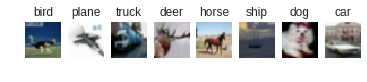

In [24]:
# To see the transformed images,
# remember to set batch_size above as 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
def imshow(inps, clss, title=None):
    """Imshow for Tensor."""
    inps = inps.numpy().transpose((0,2,3,1))
    clss = clss.numpy()
    mean = np.array([0.4914, 0.4822, 0.4465])[None,None,None,:]
    std = np.array([0.2023, 0.1994, 0.2010])[None,None,None,:]
    inps = std * inps + mean
    inps = np.clip(inps, 0, 1)
    for i in range(8):
      plt.subplot(1,8,i+1)
      plt.imshow(inps[i])
      plt.axis('off')
      plt.title(classes[clss[i]])


# Get a batch of training data
inps, clss = next(iter(loader_train))

imshow(inps, clss)

Prepare data loader

In [5]:
NUM_TRAIN = 49000

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform_train = T.Compose([
                T.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.05),
                T.RandomResizedCrop(32, scale=(0.8, 1.0)),
                T.RandomHorizontalFlip(),
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                             transform=transform_train)
loader_train = DataLoader(cifar10_train, batch_size=32, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./cs231n/datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified


Prepare function for training

In [0]:
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)


def foward_pass(x, y, model):
    model.eval()  # set model to evaluation mode
    x = x.to(device=device, dtype=dtype)
    y = y.to(device=device, dtype=torch.long)
    scores = model(x)
    l = F.cross_entropy(scores, y)
    _, preds = scores.max(1)
    num_correct = (preds == y).sum()
    num_samples = preds.size(0)
    loss = l.item()
    return num_correct, num_samples, loss


def check_accuracy(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')
    num_correct, num_samples, losses = 0, 0, []
    with torch.no_grad():
        for x, y in loader:
            n_corr, n_samples, l = foward_pass(x, y, model)
            num_correct += n_corr
            num_samples += n_samples
            losses.append(l)
    acc = float(num_correct) / num_samples
    loss = np.mean(losses)
    print('Got val loss %.4f, %d / %d correct (%.2f)' % (loss, num_correct, num_samples, 100 * acc))
    return acc, loss


def train_net(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    
    # Log the initial performance
    x, y = next(iter(loader_train))
    n_correct, n_samples, bch_loss = foward_pass(x, y, model)
    val_acc, val_loss = check_accuracy(loader_val, model)
    loss_history, val_loss_history = [bch_loss], [val_loss]
    train_acc_history, val_acc_history = [float(n_correct) / n_samples], [val_acc]
    best_val_acc = val_acc
    
    # Start training for epochs
    for e in range(epochs):
        print('\nEpoch %d / %d:' % (e + 1, epochs))
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
        
        # Checkpoint and record/print metrics at epoch end
        _, preds = scores.max(1)
        bch_acc = float((preds == y).sum()) / preds.size(0)
        bch_loss = loss.item()
        print('Batch loss %.4f, acc %.2f' % (bch_loss, 100 * bch_acc))
        val_acc, val_loss = check_accuracy(loader_val, model)
        loss_history.append(bch_loss)
        val_loss_history.append(val_loss)
        train_acc_history.append(bch_acc)
        val_acc_history.append(val_acc)
        
        if val_acc > best_val_acc:
            print('Saving model...')
            best_val_acc = val_acc
            torch.save(model.state_dict(), './best_model.pth.tar')
        print()
    
    return [train_acc_history, val_acc_history, loss_history, val_loss_history]


def reload_best(model):
    model.load_state_dict(torch.load('./best_model.pth.tar'))


# Visualize training log
def plot_history(history):
    # plot history of loss and acc
    accs, val_accs, losses, val_losses = history
    epochs = range(len(accs))
    plt.style.use('ggplot')
    fig = plt.figure(figsize=(14,5))
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(epochs, accs, '-o')
    ax1.plot(epochs, val_accs, '-o')
    ax1.set_ylim(0, 1.05)
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax1.legend(['train', 'val'], loc='lower right')
    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(epochs, losses, '-o')
    ax2.plot(epochs, val_losses, '-o')
    ax2.set_ylim(bottom=-0.1)
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss')
    ax2.legend(['train', 'val'], loc='upper right')

**VGG-style**

Checking accuracy on validation set
Got val loss 2.3045, 78 / 1000 correct (7.80)

Epoch 1 / 15:
Iteration 0, loss = 2.4744
Iteration 100, loss = 1.7488
Iteration 200, loss = 1.5416
Iteration 300, loss = 1.6090
Iteration 400, loss = 1.2861
Iteration 500, loss = 1.3451
Iteration 600, loss = 1.4451
Iteration 700, loss = 1.4654
Iteration 800, loss = 1.2679
Iteration 900, loss = 1.3374
Iteration 1000, loss = 1.2242
Iteration 1100, loss = 1.3561
Iteration 1200, loss = 1.0290
Iteration 1300, loss = 0.8744
Iteration 1400, loss = 1.4514
Iteration 1500, loss = 1.1309
Batch loss 0.5546, acc 87.50
Checking accuracy on validation set
Got val loss 0.8415, 691 / 1000 correct (69.10)
Saving model...


Epoch 2 / 15:
Iteration 0, loss = 1.5662
Iteration 100, loss = 0.9918
Iteration 200, loss = 1.3600
Iteration 300, loss = 0.9466
Iteration 400, loss = 1.0223
Iteration 500, loss = 0.8235
Iteration 600, loss = 0.9011
Iteration 700, loss = 1.5398
Iteration 800, loss = 0.9479
Iteration 900, loss = 1.4080
It

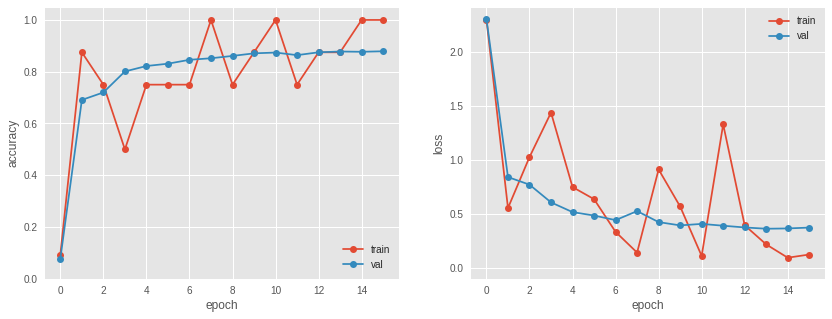

In [15]:
learning_rate = 1e-3

model = nn.Sequential(
    nn.Conv2d(3, 64, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(64, 128, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.Conv2d(128, 128, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(128, 256, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.Conv2d(256, 256, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.MaxPool2d(2, stride=2),
    Flatten(),
    nn.Linear(256 * 4 * 4, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(p=0.5),
    nn.Linear(512, 10),
)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

t0 = time()
history = train_net(model, optimizer, epochs=15)
plot_history(history)
print('Training goes with %.2f seconds.' %(time()-t0))

**Inception Net**

In [0]:
class BasicConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)


class Inception3(nn.Module):

    def __init__(self, num_classes=10):
        super(Inception3, self).__init__()
        self.Conv2d_1a_3x3 = BasicConv2d(3, 32, kernel_size=3, padding=1)
        self.Conv2d_2a_3x3 = BasicConv2d(32, 32, kernel_size=3, padding=1)
        self.Conv2d_2b_3x3 = BasicConv2d(32, 64, kernel_size=3, padding=1)
        self.Conv2d_3b_1x1 = BasicConv2d(64, 80, kernel_size=1)
        self.Conv2d_4a_3x3 = BasicConv2d(80, 192, kernel_size=3, padding=1)
        self.Mixed_5b = InceptionA(192, pool_features=32)
        self.Mixed_5c = InceptionA(256, pool_features=64)
        self.Mixed_5d = InceptionA(288, pool_features=64)
        
        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.fc = nn.Linear(288, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                import scipy.stats as stats
                stddev = m.stddev if hasattr(m, 'stddev') else 0.1
                X = stats.truncnorm(-2, 2, scale=stddev)
                values = torch.Tensor(X.rvs(m.weight.data.numel()))
                values = values.view(m.weight.data.size())
                m.weight.data.copy_(values)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):
        # 32 x 32 x 3
        x = self.Conv2d_1a_3x3(x)
        # 32 x 32 x 32
        x = self.Conv2d_2a_3x3(x)
        # 32 x 32 x 32
        x = self.Conv2d_2b_3x3(x)
        # 32 x 32 x 64
        x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)
        # 16 x 16 x 64
        x = self.Conv2d_3b_1x1(x)
        # 16 x 16 x 80
        x = self.Conv2d_4a_3x3(x)
        # 16 x 16 x 192
        x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)
        # 8 x 8 x 192
        x = self.Mixed_5b(x)
        # 8 x 8 x 256
        x = self.Mixed_5c(x)
        # 8 x 8 x 288
        x = self.Mixed_5d(x)
        # 8 x 8 x 288
        x = self.avgpool(x)
        # 1 x 1 x 288
        #x = F.dropout(x, training=self.training)
        # 1 x 1 x 288
        x = x.view(x.size(0), -1)
        # 288
        x = self.fc(x)
        # 10 (num_classes)
        return x


class InceptionA(nn.Module):

    def __init__(self, in_channels, pool_features):
        super(InceptionA, self).__init__()
        self.branch1x1 = BasicConv2d(in_channels, 64, kernel_size=1)

        self.branch5x5_1 = BasicConv2d(in_channels, 48, kernel_size=1)
        self.branch5x5_2 = BasicConv2d(48, 64, kernel_size=5, padding=2)

        self.branch3x3dbl_1 = BasicConv2d(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = BasicConv2d(96, 96, kernel_size=3, padding=1)

        self.branch_pool = BasicConv2d(in_channels, pool_features, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)

Checking accuracy on validation set
Got val loss 8.7272, 105 / 1000 correct (10.50)

Epoch 1 / 15:
Iteration 0, loss = 2.3534
Iteration 100, loss = 1.6169
Iteration 200, loss = 1.7261
Iteration 300, loss = 1.3609
Iteration 400, loss = 1.1877
Iteration 500, loss = 1.4090
Iteration 600, loss = 1.4208
Iteration 700, loss = 1.1520
Iteration 800, loss = 1.7118
Iteration 900, loss = 1.2128
Iteration 1000, loss = 1.0912
Iteration 1100, loss = 0.7995
Iteration 1200, loss = 0.9695
Iteration 1300, loss = 1.0382
Iteration 1400, loss = 0.9252
Iteration 1500, loss = 0.7668
Batch loss 1.3682, acc 37.50
Checking accuracy on validation set
Got val loss 0.8383, 716 / 1000 correct (71.60)
Saving model...


Epoch 2 / 15:
Iteration 0, loss = 0.9252
Iteration 100, loss = 0.7043
Iteration 200, loss = 0.5251
Iteration 300, loss = 1.0039
Iteration 400, loss = 0.5610
Iteration 500, loss = 0.9726
Iteration 600, loss = 0.6723
Iteration 700, loss = 0.8838
Iteration 800, loss = 0.9158
Iteration 900, loss = 0.7257


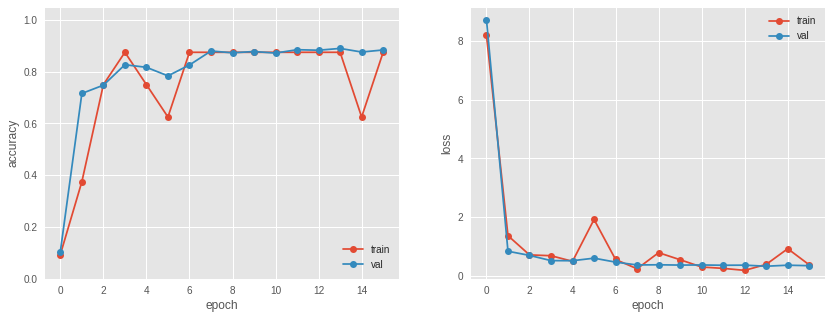

In [8]:
learning_rate = 1e-3

model = Inception3()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

t0 = time()
history = train_net(model, optimizer, epochs=15)
plot_history(history)
print('Training goes with %.2f seconds.' %(time()-t0))

**ResNet**

In [0]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=5, stride=1, padding=2,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 256, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(2, stride=1)
        self.fc = nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

Checking accuracy on validation set
Got val loss 3.6033, 105 / 1000 correct (10.50)

Epoch 1 / 15:
Iteration 0, loss = 2.3781
Iteration 100, loss = 1.8955
Iteration 200, loss = 1.7034
Iteration 300, loss = 1.7413
Iteration 400, loss = 1.7785
Iteration 500, loss = 1.6483
Iteration 600, loss = 1.3379
Iteration 700, loss = 1.4807
Iteration 800, loss = 2.0411
Iteration 900, loss = 1.3866
Iteration 1000, loss = 1.4974
Iteration 1100, loss = 1.0960
Iteration 1200, loss = 1.2848
Iteration 1300, loss = 1.1905
Iteration 1400, loss = 1.0408
Iteration 1500, loss = 1.3946
Batch loss 0.7228, acc 62.50
Checking accuracy on validation set
Got val loss 1.0639, 642 / 1000 correct (64.20)
Saving model...


Epoch 2 / 15:
Iteration 0, loss = 1.2151
Iteration 100, loss = 1.3666
Iteration 200, loss = 0.9541
Iteration 300, loss = 1.3264
Iteration 400, loss = 1.1710
Iteration 500, loss = 0.8301
Iteration 600, loss = 0.9763
Iteration 700, loss = 0.8738
Iteration 800, loss = 0.7446
Iteration 900, loss = 0.7924


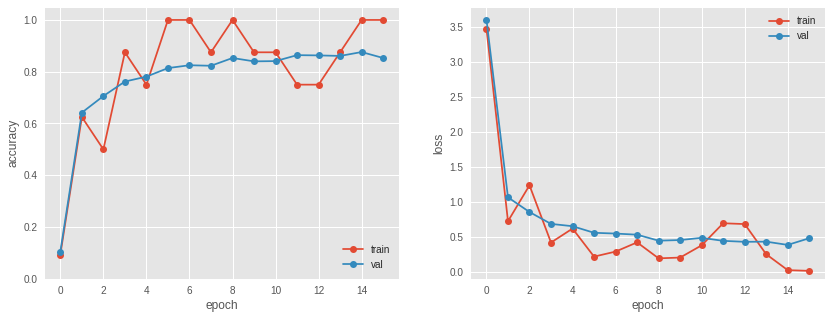

In [14]:
learning_rate = 1e-3

# kernel=5, stride=1, 4 stages
model = ResNet(BasicBlock, [2, 3, 5, 2])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

t0 = time()
history = train_net(model, optimizer, epochs=15)
plot_history(history)
print('Training goes with %.2f seconds.' %(time()-t0))

**DenseNet**

In [0]:
from collections import OrderedDict

class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                        growth_rate, kernel_size=1, stride=1, bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                        kernel_size=3, stride=1, padding=1, bias=False)),
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = super(_DenseLayer, self).forward(x)
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)


class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i * growth_rate, growth_rate, bn_size, drop_rate)
            self.add_module('denselayer%d' % (i + 1), layer)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class DenseNet(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
    """
    def __init__(self, growth_rate=32, block_config=(6, 12, 24),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=10):

        super(DenseNet, self).__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=5, stride=1, padding=2, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.avg_pool2d(out, kernel_size=4, stride=1).view(features.size(0), -1)
        out = self.classifier(out)
        return out

Checking accuracy on validation set
Got val loss 2.5171, 107 / 1000 correct (10.70)

Epoch 1 / 15:
Iteration 0, loss = 2.3201
Iteration 100, loss = 1.8585
Iteration 200, loss = 1.8266
Iteration 300, loss = 1.4975
Iteration 400, loss = 1.3483
Iteration 500, loss = 1.4079
Iteration 600, loss = 0.9488
Iteration 700, loss = 1.2475
Iteration 800, loss = 1.1679
Iteration 900, loss = 1.2452
Iteration 1000, loss = 1.1293
Iteration 1100, loss = 0.9556
Iteration 1200, loss = 1.1819
Iteration 1300, loss = 0.8984
Iteration 1400, loss = 1.0251
Iteration 1500, loss = 0.8102
Batch loss 1.2083, acc 50.00
Checking accuracy on validation set
Got val loss 0.9620, 679 / 1000 correct (67.90)
Saving model...


Epoch 2 / 15:
Iteration 0, loss = 1.0589
Iteration 100, loss = 1.1884
Iteration 200, loss = 0.7062
Iteration 300, loss = 0.8435
Iteration 400, loss = 1.1350
Iteration 500, loss = 1.3208
Iteration 600, loss = 0.8780
Iteration 700, loss = 1.2750
Iteration 800, loss = 1.1952
Iteration 900, loss = 0.9905


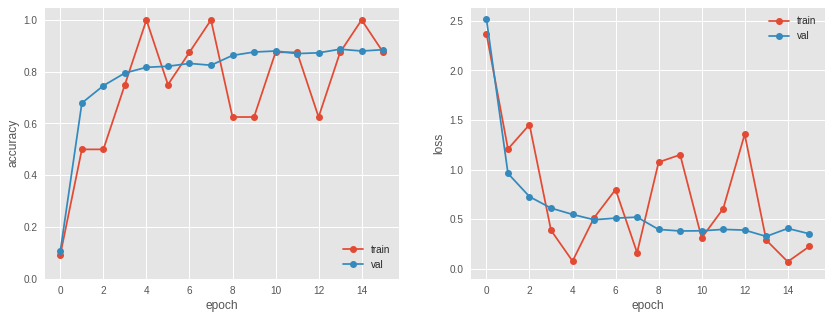

In [8]:
# blocks [6, 12, 24], growth rate 32
learning_rate = 1e-3

model = DenseNet()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

t0 = time()
history = train_net(model, optimizer, epochs=15)
plot_history(history)
print('Training goes with %.2f seconds.' %(time()-t0))

## Describe what you did 

In the cell below you should write an explanation of what you did, any additional features that you implemented, and/or any graphs that you made in the process of training and evaluating your network.

TODO: Describe what you did

## Test set -- run this only once

Now that we've gotten a result we're happy with, we test our final model on the test set (which you should store in best_model). Think about how this compares to your validation set accuracy.

**VGG-style**

In [19]:
model.load_state_dict(torch.load('./vgg.pth.tar'))
best_model = model.to(device=device)  # move the model parameters to CPU/GPU
check_accuracy(loader_val, best_model)

Checking accuracy on validation set
Got val loss 0.3784, 879 / 1000 correct (87.90)


(0.879, 0.3784138672053814)

In [20]:
check_accuracy(loader_test, best_model)

Checking accuracy on test set
Got val loss 0.3808, 8770 / 10000 correct (87.70)


(0.877, 0.3808383654067471)

**Inception Net**

In [12]:
model = Inception3()
model.load_state_dict(torch.load('./inception.pth.tar'))
best_model = model.to(device=device)  # move the model parameters to CPU/GPU
check_accuracy(loader_val, best_model)

Checking accuracy on validation set
Got val loss 0.3313, 890 / 1000 correct (89.00)


(0.89, 0.33133223559707403)

In [13]:
check_accuracy(loader_test, best_model)

Checking accuracy on test set
Got val loss 0.3618, 8793 / 10000 correct (87.93)


(0.8793, 0.36183775510567767)

**ResNet**

In [24]:
model = DenseNet()
model.load_state_dict(torch.load('./denseNet.pth.tar'))
best_model = model.to(device=device)  # move the model parameters to CPU/GPU
check_accuracy(loader_val, best_model)

Checking accuracy on validation set
Got val loss 0.3217, 887 / 1000 correct (88.70)


(0.887, 0.321684742346406)

In [25]:
check_accuracy(loader_test, best_model)

Checking accuracy on test set
Got val loss 0.3844, 8732 / 10000 correct (87.32)


(0.8732, 0.3844305277819846)

**DenseNet**

In [26]:
model = ResNet(BasicBlock, [2, 3, 5, 2])
model.load_state_dict(torch.load('./resNet.pth.tar'))
best_model = model.to(device=device)  # move the model parameters to CPU/GPU
check_accuracy(loader_val, best_model)

Checking accuracy on validation set
Got val loss 0.3922, 876 / 1000 correct (87.60)


(0.876, 0.3921981491148472)

In [27]:
check_accuracy(loader_test, best_model)

Checking accuracy on test set
Got val loss 0.4677, 8517 / 10000 correct (85.17)


(0.8517, 0.4677149132368671)